<a href="https://colab.research.google.com/github/inrok86/cbpc/blob/main/cnn_pre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensorflow example

https://www.tensorflow.org/tutorials/images/transfer_learning

이미 학습된 CNN 모델을 기반으로 개/고양이를 분류할 수 있는 모델을 학습

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

## 데이터 불러오기

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [3]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


## 데이터 보기

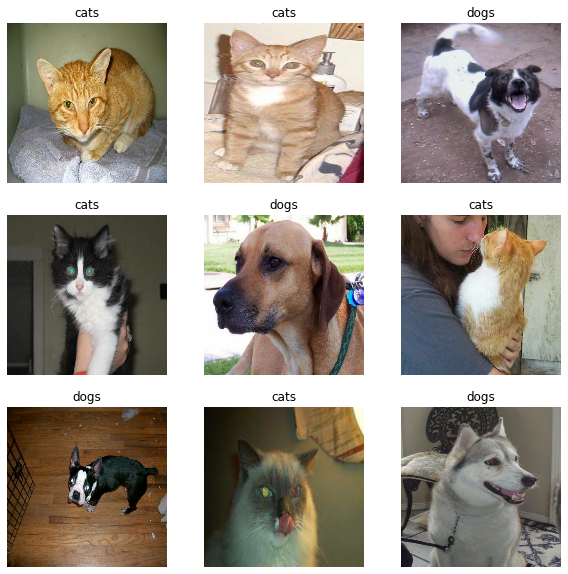

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## 데이터 증강: flip and rotate

In [7]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

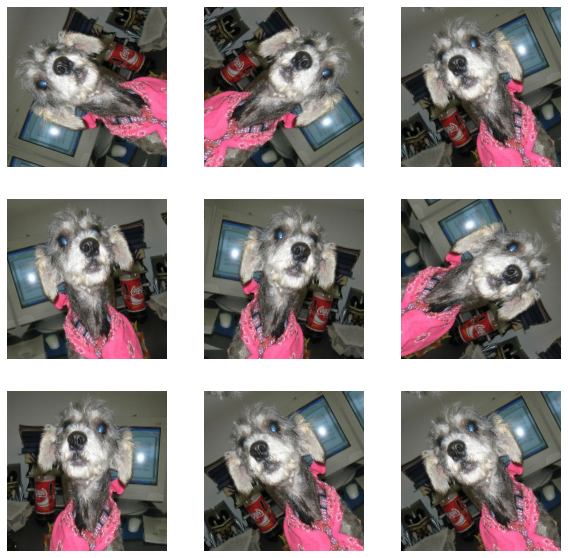

In [8]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)


## 사전 학습된 모델 불러오기

In [10]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [11]:
base_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print("freature batch:",feature_batch_average.shape)
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print("prediction layer:",prediction_batch.shape)

freature batch: (32, 1280)
prediction layer: (32, 1)


## 새로운 모델 설계

In [12]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [13]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
print("trainable :",len(model.trainable_variables))

trainable : 2


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [14]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

26/26 [==============================] - 3s 35ms/step - loss: 0.8896 - accuracy: 0.4208
initial loss: 0.89
initial accuracy: 0.42


In [15]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 7s 61ms/step - loss: 0.6959 - accuracy: 0.5925 - val_loss: 0.5682 - val_accuracy: 0.7017
Epoch 2/10
63/63 [==============================] - 4s 60ms/step - loss: 0.5218 - accuracy: 0.7270 - val_loss: 0.3952 - val_accuracy: 0.8230
Epoch 3/10
63/63 [==============================] - 4s 59ms/step - loss: 0.4089 - accuracy: 0.7930 - val_loss: 0.2978 - val_accuracy: 0.8948
Epoch 4/10
63/63 [==============================] - 4s 59ms/step - loss: 0.3348 - accuracy: 0.8440 - val_loss: 0.2330 - val_accuracy: 0.9183
Epoch 5/10
63/63 [==============================] - 4s 60ms/step - loss: 0.2887 - accuracy: 0.8750 - val_loss: 0.1929 - val_accuracy: 0.9295
Epoch 6/10
63/63 [==============================] - 4s 58ms/step - loss: 0.2538 - accuracy: 0.8885 - val_loss: 0.1650 - val_accuracy: 0.9381
Epoch 7/10
63/63 [==============================] - 4s 58ms/step - loss: 0.2356 - accuracy: 0.8885 - val_loss: 0.1481 - val_accuracy: 0.9455
Epoch 8/10
63

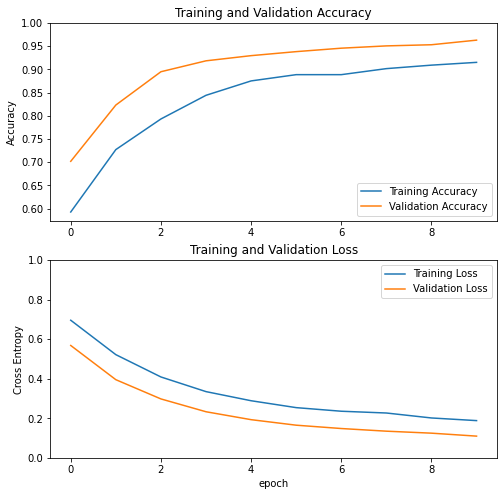

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning

In [17]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [18]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [19]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 9s 76ms/step - loss: 0.1640 - accuracy: 0.9265 - val_loss: 0.0585 - val_accuracy: 0.9790
Epoch 11/20
63/63 [==============================] - 4s 65ms/step - loss: 0.1157 - accuracy: 0.9465 - val_loss: 0.0461 - val_accuracy: 0.9839
Epoch 12/20
63/63 [==============================] - 4s 66ms/step - loss: 0.0941 - accuracy: 0.9620 - val_loss: 0.0456 - val_accuracy: 0.9851
Epoch 13/20
63/63 [==============================] - 4s 66ms/step - loss: 0.1013 - accuracy: 0.9580 - val_loss: 0.0501 - val_accuracy: 0.9765
Epoch 14/20
63/63 [==============================] - 4s 68ms/step - loss: 0.0793 - accuracy: 0.9680 - val_loss: 0.0401 - val_accuracy: 0.9851
Epoch 15/20
63/63 [==============================] - 4s 64ms/step - loss: 0.0881 - accuracy: 0.9640 - val_loss: 0.0430 - val_accuracy: 0.9814
Epoch 16/20
63/63 [==============================] - 4s 65ms/step - loss: 0.0826 - accuracy: 0.9625 - val_loss: 0.0396 - val_accuracy: 0.9851
Epoch 

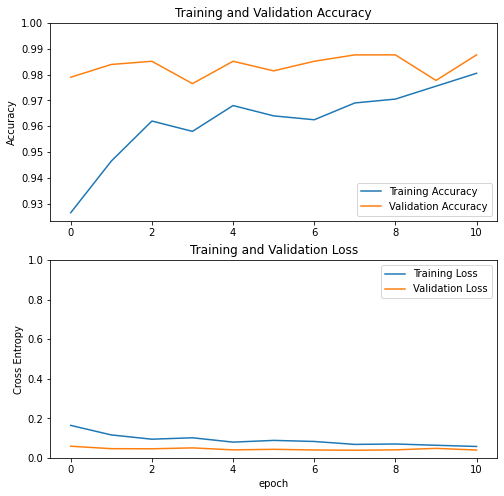

In [21]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()